# Sinsistro template

* https://observe.lco.global/requests/3867164
* https://observe.lco.global/requests/3867165

In [1]:
import sys
sys.path.insert(0, "/ut3/jerome/github/research/project/ext_tools/prose/")

In [2]:
from astropy.time import Time
#timings from NTES
ing0 = Time("2025-05-23 18:42", format='iso').jd,0.01
mid0 = Time("2025-05-23 19:59", format='iso').jd,0.01
egr0 = Time("2025-05-23 21:16", format='iso').jd,0.01

## dataset

In [3]:
import os
from glob import glob
from pathlib import Path

folder = Path("/data/Sinistro/250523/")

sciences = sorted(glob(str(folder / "*.fits")))
sciences

['/data/Sinistro/250523/cpt1m012-fa06-20250523-0090-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0091-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0092-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0093-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0094-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0095-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0096-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0097-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0098-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0099-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0100-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0101-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0102-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0103-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0104-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0105-e91

In [4]:
len(sciences)

1377

In [5]:
from prose import FITSImage

h = FITSImage(sciences[-1]).header
target_name = h['OBJECT']
target_name

/ut3/jerome/github/research/project/ext_tools/prose/prose/console_utils.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


'TIC89071445'

In [6]:
from astropy.io import fits
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

bands = "gp zs".split()
data = {b: [] for b in bands}

def process_file(fp):
    try:
        header = fits.getheader(fp, memmap=True)
        if header['OBJECT'] == target_name:
            band = header['FILTER']
            if band in data:
                return band, fp
    except Exception as e:
        return None  # skip corrupted/missing headers
    return None

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_file, sciences), total=len(sciences)))

for result in results:
    if result:
        band, fp = result
        data[band].append(fp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1377/1377 [00:07<00:00, 180.84it/s]


In [7]:
# count
{b: len(data[b]) for b in bands}

{'gp': 680, 'zs': 697}

## get target coords

In [8]:
from urllib.request import urlopen
import json

url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name.replace(' ','')}&json"
response = urlopen(url)
data_json = json.loads(response.read())
data_json['coordinates']

{'ra': '232.95502667627599',
 'dec': '-34.2705520935164',
 'galactic_long': '336.9213',
 'galactic_lat': '17.8095',
 'ecliptic_long': '239.0181',
 'ecliptic_lat': '-14.72988',
 'pm_ra': '-21.8677',
 'pm_ra_error': '.0960371',
 'pm_dec': '-28.8572',
 'pm_dec_error': '.0662624'}

In [9]:
ra  = float(data_json['coordinates']['ra'])      # target coord in deg
dec = float(data_json['coordinates']['dec'])       # target coord in deg
ra, dec

(232.955026676276, -34.2705520935164)

## get header info

https://lco.global/observatory/instruments/muscat/#:~:text=MuSCAT3%20Release%20Notes%20Version%201.3,1.1%20from%20Jan%2029%202024

https://lco.global/observatory/instruments/sinistro/

In [10]:
if (h['SITEID']=='coj') & (h['TELID']=='2m0a'):
    inst = 'MuSCAT4'
    saturation_limits = {
    'gp': 64000,
    'rp': 64000,
    'ip': 46000,
    'zs': 64000,
    }
elif (h['SITEID']=='ogg') & (h['TELID']=='2m0a'):
    inst = 'MuSCAT3'
    saturation_limits = {
    'gp': 120000/1.9,
    'rp': 120000/1.88,
    'ip': 82000/1.8,
    'zs': 100000/2.,
    }
    
elif (h['SITEID'] in ['lsc','cpt','coj']) & (h['TELID']=='1m0a'):
    inst = 'Sinistro'
    saturation_limits = {
        # 'gp': 340000/6.6,
        # 'zs': 340000/6.6,
        'gp': 340000/2,
        'zs': 340000/2,
    }
else:
    raise ValueError("what data is this?")

## make ref image

In [12]:
from prose import Block
from prose.core.source import Sources
import numpy as np

class MaskSaturatedPixels(Block):
    def __init__(self, saturation_level=None, name=None):
        """Mask saturated pixels in the image.
        
        Parameters
        ----------
        saturation_level : float, optional
            The level above which a pixel is considered saturated.
            If None, will use image.saturation_level if available.
        name : str, optional
            Name of the block, by default None
        """
        super().__init__(name=name)
        self.saturation_level = saturation_level
        
    def run(self, image):
        # Determine saturation level
        sat_level = self.saturation_level
        if sat_level is None and hasattr(image, 'saturation_level'):
            sat_level = image.saturation_level
        
        if sat_level is None:
            raise ValueError("No saturation level provided or found in image")
        
        # Store original data
        if not hasattr(image, 'original_data'):
            image.original_data = image.data.copy()
        
        # Mask saturated pixels with NaN or median value
        mask = image.data >= sat_level
        if mask.any():
            # Option 1: Replace with NaN
            # image.data = image.data.copy()
            # image.data[mask] = np.nan
            
            # Option 2: Replace with median (might be better for detection algorithms)
            median_value = np.nanmedian(image.data)
            image.data = image.data.copy()
            image.data[mask] = median_value
            
class RejectSaturatedSources(Block):
    def __init__(self, saturation_level=None, name=None):
        """Filter out saturated sources from the detected sources.
        
        Parameters
        ----------
        saturation_level : float, optional
            The level above which a star is considered saturated.
            If None, will use image.saturation_level if available.
        name : str, optional
            Name of the block, by default None
        """
        super().__init__(name=name)
        self.saturation_level = saturation_level
        
    def run(self, image):
        if len(image.sources) == 0:
            return
            
        # Determine saturation level
        sat_level = self.saturation_level
        if sat_level is None and hasattr(image, 'saturation_level'):
            sat_level = image.saturation_level
        
        if sat_level is None:
            raise ValueError("No saturation level provided or found in image")
            
        # Filter out sources with peak values above saturation level
        non_saturated = [s for s in image.sources if s.peak < sat_level]
        image.sources = Sources(non_saturated, type=image.sources.type)

In [162]:
from prose import Telescope

band = 'gp'
# band = 'zs'
ndata = len(data[band])
saturation = saturation_limits[band]
telescope = Telescope(saturation=saturation)
ref_file = data[band][ndata//2]
ref = FITSImage(ref_file, telescope=telescope)

In [163]:
ref.__dict__.keys()

dict_keys(['data', 'metadata', 'catalogs', '_sources', 'origin', 'discard', 'computed', 'header', '_wcs'])

In [167]:
from prose import Sequence, blocks

nstars = 10
cutout_shape = 35
saturation = saturation_limits[band]
calibration = Sequence(
        [
            blocks.Trim((20,0), skip_wcs=False),
            # MaskSaturatedPixels(saturation),
            blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # stars detection
            RejectSaturatedSources(saturation),
            blocks.Cutouts(shape=cutout_shape),  # stars cutouts
            blocks.MedianEPSF(),  # building EPSF
            blocks.psf.Moffat2D(),  # modeling EPSF
            blocks.CentroidQuadratic(),  # centroiding
            blocks.AperturePhotometry(),  # aperture photometry
            blocks.AnnulusBackground(),  # annulus background
        ]
    )

calibration.run(ref, show_progress=False)

## plot ref image

Text(0.5, 1.1, 'TIC89071445 gp-band')

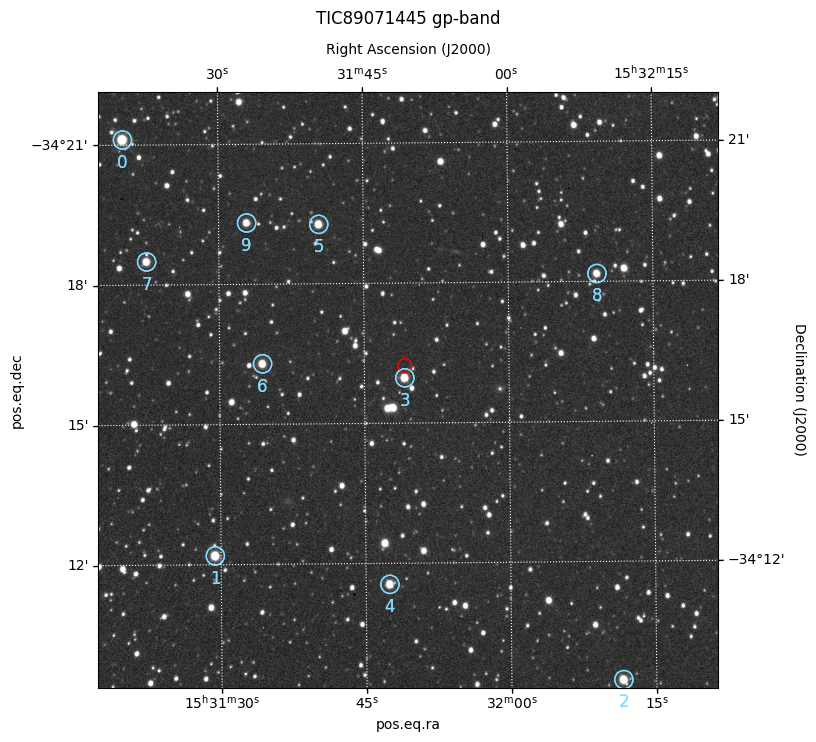

In [165]:
import matplotlib.pyplot as pl
from astropy.wcs import WCS

wcs = WCS(ref.header)
ref.show(frame=True)
ra_pix, dec_pix = wcs.wcs_world2pix([[ra,dec]], 0)[0]
pl.scatter(ra_pix, dec_pix, s=100, ec='r', fc='none')
ref.sources.plot()
pl.title(f"{target_name} {b}-band", y=1.1)

## create video

In [39]:
# Just running it on a test image

band = 'gp'
test_file = data[band][10]
test_image = FITSImage(test_file, telescope=telescope)

main_sequence = Sequence([
    calibration[0],
    blocks.PointSourceDetection(n=12, minor_length=8),  # fewer stars detection
    blocks.Cutouts(21),  # stars cutouts
    blocks.MedianEPSF(),  # building EPSF
    blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
    blocks.ComputeTransformTwirl(ref),  # compute alignment
    blocks.AlignReferenceSources(ref),  # alignment
    blocks.CentroidQuadratic(),  # centroiding
])

main_sequence.run(test_image)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50images/s]


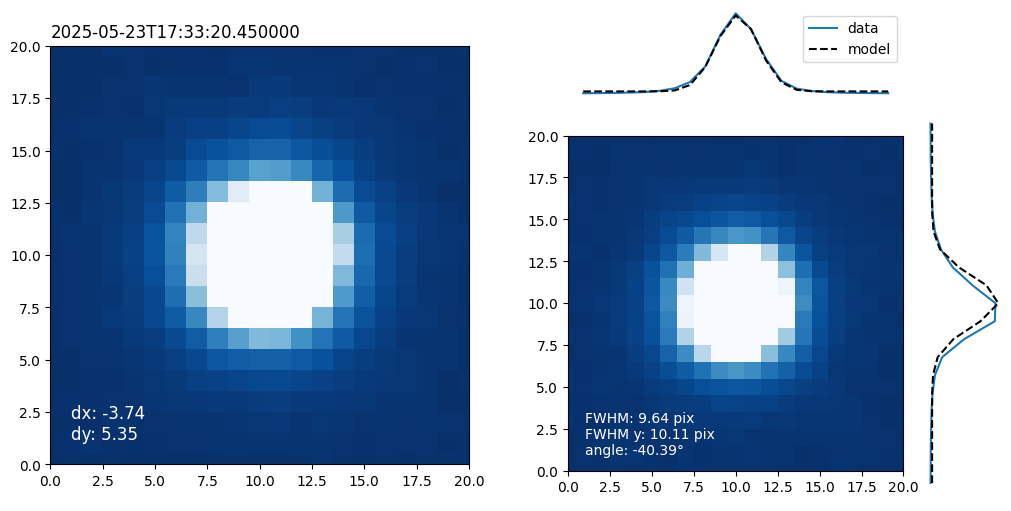

In [157]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from prose import viz

# focusing plot on
# xy = ref.stars_coords[3]
xy = ra_pix, dec_pix
cutout_shape = (120,120)

def plot(image, star_id=0):
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)

    # Alignment
    subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1.])
    ax = subfigs[0].subplots(1, 1)
    # ref.cutout(xy, shape=cutout_shape).show(ax=ax, cmap="Greys_r", sources=False)
    # ax.plot(*ref.sources[star_id].coords.T, "+", c="C0", label="reference")
    # image.cutout(xy, shape=cutout_shape).show(ax=ax, cmap="Blues_r", sources=False)
    image.cutouts[star_id].show(ax=ax, cmap="Blues_r", sources=False)
    # ax.plot(*image.sources[star_id].coords.T, "+", c="k", label="detected")
    dx, dy = image.computed['transform'].translation
    viz.corner_text(f"dx: {dx:.2f}\ndy: {dy:.2f}", c="w")
    ax.set_title(image.date.isoformat(), loc="left")
    # plt.legend()

    # PSF
    axes = subfigs[1].subplots(2, 2, gridspec_kw=dict(
        width_ratios=[9, 2],
        height_ratios=[2, 9],
        wspace=0,
        hspace=0))

    ax = axes[1, 0]
    axr = axes[1, 1]
    axt = axes[0, 0]
    axes[0, 1].axis("off")
    image.epsf.show(ax=ax, cmap="Blues_r")

    x, y = np.indices(image.epsf.shape)
    axt.plot(y[0], np.mean(image.epsf.data, axis=0), c="C0", label="data")
    params = image.epsf.computed['params']
    axt.plot(y[0], np.mean(image.epsf.model(params), axis=0), "--", c="k", label="model")
    axt.axis("off")
    axt.legend()

    axr.plot(np.mean(image.epsf.data, axis=1), y[0], c="C0", label="data")
    axr.plot(np.mean(image.epsf.model(params), axis=0), y[0], "--", c="k", label="model")    
    axr.axis("off")
    ax.text(1, 1, f"FWHM: {image.epsf.computed['params']['x']:.2f} pix\n"
                f"FWHM y: {image.epsf.computed['params']['y']:.2f} pix\n"
                f"angle: {image.epsf.computed['params']['theta']/np.pi*180:.2f}°", 
            c="w")
    # plt.tight_layout()

# Here is the result
plot(test_image)

In [158]:
data[band][::50]

['/data/Sinistro/250523/cpt1m012-fa06-20250523-0090-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0140-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0190-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0240-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0290-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0340-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0390-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0440-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0490-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0540-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0590-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0640-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0690-e91.fits',
 '/data/Sinistro/250523/cpt1m012-fa06-20250523-0740-e91.fits']

In [159]:
process = Sequence([
    *main_sequence,
    blocks.visualization.VideoPlot(plot, "movie.gif")
])

# only 10 images for example
process.run(data[band][::50])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47images/s]


In [ ]:
from astroquery.simbad import Simbad
from astropy.visualization.wcsaxes import SphericalCircle 
from astropy.coordinates import SkyCoord
import matplotlib.patches as mpatches
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.wcs import WCS

fovs = {
    'sinistro_full': 13*60, #CONFMODE= 'full_frame'
    'sinistro_2x2': 26.5*60, #CONFMODE= 'central_2k_2x2'
    'muscat': 6.1, 
    'muscat2': 7.4, #7.4 × 7.4
    'muscat3': 9.1,
    'muscat4': 9.1
    
}

def get_simbad_data(target_coord, inst, fov_arcsec=None):
    """
    See Simbad object types:
    https://simbad.cds.unistra.fr/Pages/guide/otypes.htx
    """
    Simbad.add_votable_fields("otype")

    if inst.lower()=='sinistro':
        inst += '_2x2'
    fov_inst = fovs[inst]*60
    fov = fov_arcsec if fov_arcsec else fov_inst
    msg = f'Querying Simbad sources {fov}" around {target_name}: '
    # FIXME: should we query around the center of FOV?
    msg += f"({target_coord.ra.deg:.4f}, {target_coord.dec.deg:.4f}) deg."
    print(msg)
    
    df = Simbad.query_region(target_coord, 
                             radius=fov*u.arcsec).to_pandas()
    url = "https://simbad.cds.unistra.fr/Pages/guide/otypes.htx"
    print(f"See Simbad object types: {url}")
    # limit
    coords = SkyCoord(ra=df.RA, dec=df.DEC, 
                      unit=(u.hourangle,u.degree))
    idx = coords.separation(self.target_coord)<fov*u.arcsec
    return df[idx]

def plot_fov_simbad(
    ax,
    target_coord,
    inst : str = 'sinistro',
    fov_simbad_arcsec : float = None,
    text_offset: tuple = (0, 0),
    phot_aper_pix: int = 10,
    cmap_marker: str = 'hsv',
    title: str = None,
    suffix: str = "pdf",
):
    """
    Simbad object types within Field of View
    """
    dr, dd = text_offset
    # superpose simbad sources
    simbad_data = get_simbad_data(target_coord,
                                  inst=inst,
                                  fov_arcsec=fov_simbad_arcsec
                                 )
    otypes = list(simbad_data['OTYPE'].unique())
    color_map = plt.get_cmap(cmap_marker)
    obj_colors = color_map(np.linspace(0, 1, len(otypes)))
    color_mapping = {t: obj_colors[i] for i, t in enumerate(otypes)}

    coords = SkyCoord(ra=simbad_data.RA, dec=simbad_data.DEC, 
                      unit=(u.hourangle,u.degree))
    obj_coords = np.c_[coords.ra.deg,coords.dec.deg]
    for i, (r, d) in enumerate(obj_coords):
        t = simbad_data.iloc[i]['OTYPE']
        c = SphericalCircle(
            (r * u.deg, d * u.deg),
            rad_marker * u.arcsec,
            edgecolor=color_mapping[t],
            facecolor="none",
            lw=2,
            transform=ax.get_transform("fk5"),
        )
        ax.add_patch(c)
        ax.text(
            r + dr,
            d + dd,
            t,
            fontsize=20,
            color=color_mapping[t],
            transform=ax.get_transform("fk5"),
        )
    ax.set_xlim(0, data.shape[1])
    ax.set_ylim(0, data.shape[0])
    fig.suptitle(title, y=title_height, fontsize=font_size)
    ax.set_ylabel("Dec")
    ax.set_xlabel("RA")
    # add legend
    patches = [mpatches.Patch(color=mc, label=lbl) for mc,lbl in zip(mcolors,labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


wcs = WCS(ref.header)

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(
    top=0.95
)  # Adjusted subplots_adjust to give more space to the title
ax = fig.add_subplot(111, projection=wcs)

ref.show(ax=ax, frame=True)
ra_pix, dec_pix = wcs.wcs_world2pix([[ra,dec]], 0)[0]
plt.scatter(ra_pix, dec_pix, s=100, ec='r', fc='none')
ref.sources.plot(ax=ax)
plt.title(f"{target_name} {b}-band", y=1.1)

target_coord = SkyCoord(ra, dec, unit='deg')
fig = plot_fov_simbad(ax, target_coord)
fig.tight_layout()
if False:
    outfile = f"{self.outfile_prefix}_{band[0]}_FOV_simbad.{suffix}"
    fig.savefig(outfile, dpi=300)

## check detected reference stars

In [18]:
ref.computed.keys()

dict_keys(['telescope', 'i', 'cutouts', 'epsf', 'epsf_n_sources', 'fwhm', 'aperture', 'annulus'])

In [19]:
len(ref.computed['cutouts'])

10

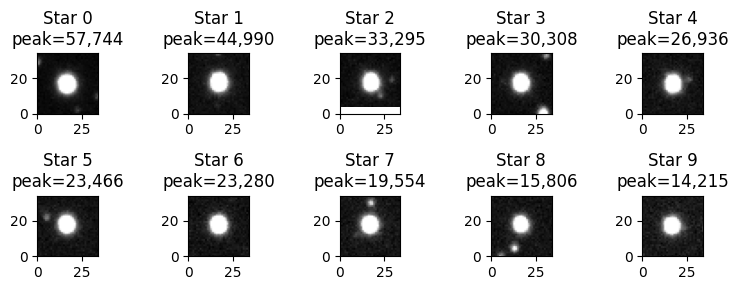

In [79]:
import matplotlib.pyplot as pl

ncutouts = len(ref.computed['cutouts'])
nrows = 2
fig, axs = pl.subplots(nrows, ncutouts//nrows, figsize=(8,3), tight_layout=True)
ax = axs.flatten()
for i,img in enumerate(ref.computed['cutouts']):
    img.show(ax=ax[i])
    peak = ref._sources[i].peak
    # peak = np.nanmax(img.data)
    ax[i].set_title(f"Star {i}\npeak={peak:,.0f}")
fig.suptitle(f"{b}-band")

In [21]:
ref.computed.keys()

dict_keys(['telescope', 'i', 'cutouts', 'epsf', 'epsf_n_sources', 'fwhm', 'aperture', 'annulus'])

In [22]:
ref.aperture.keys()

dict_keys(['fluxes', 'radii'])

In [23]:
ref.aperture['radii']

array([ 0.64361128,  0.75913594,  0.89539663,  1.05611536,  1.24568222,
        1.46927528,  1.73300205,  2.04406631,  2.41096489,  2.84371973,
        3.35415167,  3.9562033 ,  4.66631988,  5.50389844,  6.49181771,
        7.65706302,  9.0314634 , 10.65256104, 12.56463672, 14.8199194 ,
       17.48001281, 20.61757826, 24.31831931, 28.68332288, 33.83182041,
       39.90444471, 47.06707143, 55.51534996, 65.48004767, 77.23335341])

## plot nearby stars

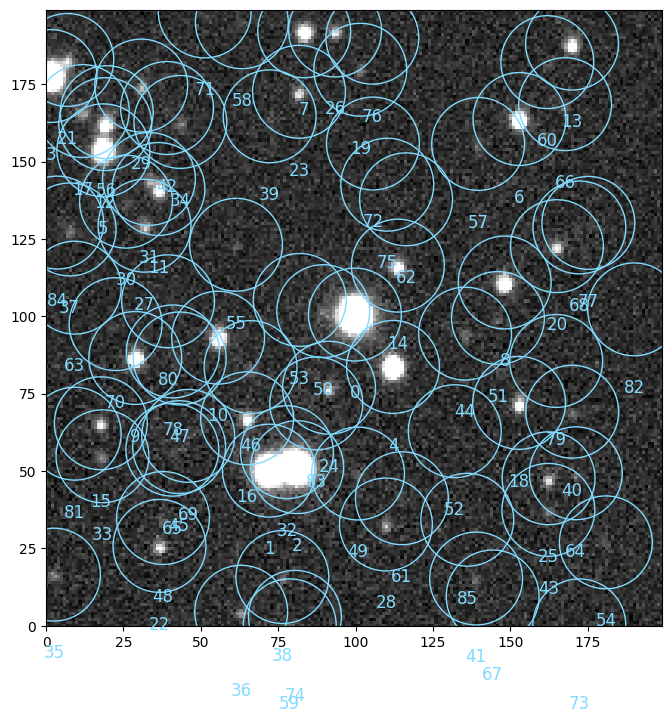

In [24]:
from prose.blocks import catalogs
import astropy.units as u

if b=='gp':
    tid = 3 #target id
elif b=='zs':
    tid = 0
else:
    raise ValueError("Which band is this?")
    
# c = ref.computed['cutouts'][tid] #orig cutout too small
c = ref.cutout(ref.sources[tid].coords, (200, 200)) #make a larger cutout to see nearby Gaia sources

c.fov = c.shape*ref.header['pixscale']*u.arcsec #need to add fov attribute before querying Gaia
c = catalogs.GaiaCatalog(mode="replace")(c)
# mode="crossmatch" to match existing Image.sources 
# mode="replace" to use queried stars as Image.sources
c.show()

In [25]:
c.catalogs['gaia'].head()

,index,solution_id,id,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,x,y
0,0,1635721458409799680,Gaia DR2 6014331902471694464,6014331902471694464,483270431,2015.5,232.954953,0.056645,-34.270632,0.031277,...,1.045749,0.896411,1.117964,0.271078,0.268560,0.273596,https://gea.esac.esa.int/data-server/datalink/...,,99.762002,100.563709
1,1,1635721458409799680,Gaia DR2 6014331906769737984,6014331906769737984,1289316337,2015.5,232.947570,0.069263,-34.259775,0.036196,...,0.994210,0.913827,1.074304,0.181338,0.179564,0.183112,https://gea.esac.esa.int/data-server/datalink/...,,71.993920,50.131684
2,2,1635721458409799680,Gaia DR2 6014331906769737856,6014331906769737856,627321601,2015.5,232.949959,0.040060,-34.260000,0.019198,...,1.447507,1.396697,1.511825,1.190238,1.142158,1.238319,https://gea.esac.esa.int/data-server/datalink/...,,81.110876,51.252203
3,3,1635721458409799680,Gaia DR2 6014330394941243392,6014330394941243392,1111942320,2015.5,232.929384,0.040637,-34.287484,0.022556,...,1.908165,1.533652,2.284996,2.174774,1.970118,2.379430,https://gea.esac.esa.int/data-server/datalink/...,,1.428171,177.618525
4,4,1635721458409799680,Gaia DR2 6014331906769736448,6014331906769736448,114859943,2015.5,232.958136,0.063136,-34.266947,0.030620,...,1.102655,1.011260,1.223113,0.550233,0.500233,0.600233,https://gea.esac.esa.int/data-server/datalink/...,,112.069602,83.634285


## determine nearest star

In [26]:
df = c.catalogs['gaia'].copy()
df.head()

,index,solution_id,id,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,x,y
0,0,1635721458409799680,Gaia DR2 6014331902471694464,6014331902471694464,483270431,2015.5,232.954953,0.056645,-34.270632,0.031277,...,1.045749,0.896411,1.117964,0.271078,0.268560,0.273596,https://gea.esac.esa.int/data-server/datalink/...,,99.762002,100.563709
1,1,1635721458409799680,Gaia DR2 6014331906769737984,6014331906769737984,1289316337,2015.5,232.947570,0.069263,-34.259775,0.036196,...,0.994210,0.913827,1.074304,0.181338,0.179564,0.183112,https://gea.esac.esa.int/data-server/datalink/...,,71.993920,50.131684
2,2,1635721458409799680,Gaia DR2 6014331906769737856,6014331906769737856,627321601,2015.5,232.949959,0.040060,-34.260000,0.019198,...,1.447507,1.396697,1.511825,1.190238,1.142158,1.238319,https://gea.esac.esa.int/data-server/datalink/...,,81.110876,51.252203
3,3,1635721458409799680,Gaia DR2 6014330394941243392,6014330394941243392,1111942320,2015.5,232.929384,0.040637,-34.287484,0.022556,...,1.908165,1.533652,2.284996,2.174774,1.970118,2.379430,https://gea.esac.esa.int/data-server/datalink/...,,1.428171,177.618525
4,4,1635721458409799680,Gaia DR2 6014331906769736448,6014331906769736448,114859943,2015.5,232.958136,0.063136,-34.266947,0.030620,...,1.102655,1.011260,1.223113,0.550233,0.500233,0.600233,https://gea.esac.esa.int/data-server/datalink/...,,112.069602,83.634285


In [27]:
from astropy.coordinates import SkyCoord

target_coord = SkyCoord(ra, dec, unit='deg')
gaia_coords = SkyCoord(df.ra, df.dec, unit='deg')

In [28]:
df['sep_arcsec'] = target_coord.separation(gaia_coords).arcsec
df['sep_pix'] = (df['sep_arcsec']/ref.header['PIXSCALE']).round() #pixel
df = df.sort_values(by='sep_arcsec').reset_index(drop=True)
df.sep_pix.head()

0     0.0
1    11.0
2    19.0
3    20.0
4    21.0
Name: sep_pix, dtype: float64

In [29]:
#nearest star
aper_rad_max_pix = 20 #df.iloc[1].sep_pix
aper_rad_max_pix

20

In [30]:
aper_rad_min_pix = round(ref.fwhm)
aper_rad_min_pix

6

In [31]:
assert aper_rad_min_pix<aper_rad_max_pix

In [32]:
default_radii = ref.aperture['radii']
len(default_radii)

30

In [33]:
import numpy as np

# the default aperture radii in blocks.AperturePhotometry() is scaled by fwhm like so:
np.exp(np.linspace(np.log(0.1), np.log(12), 30))*ref.fwhm

array([ 0.64361128,  0.75913594,  0.89539663,  1.05611536,  1.24568222,
        1.46927528,  1.73300205,  2.04406631,  2.41096489,  2.84371973,
        3.35415167,  3.9562033 ,  4.66631988,  5.50389844,  6.49181771,
        7.65706302,  9.0314634 , 10.65256104, 12.56463672, 14.8199194 ,
       17.48001281, 20.61757826, 24.31831931, 28.68332288, 33.83182041,
       39.90444471, 47.06707143, 55.51534996, 65.48004767, 77.23335341])

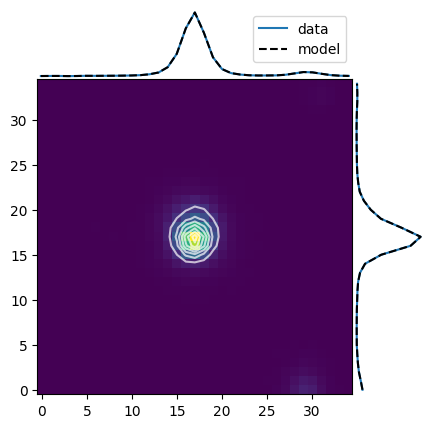

In [34]:
# how's the FWHM like?
c = ref.computed['cutouts'][tid]
c.plot_model(c.data, contour=True)

## set aperture radii and background annulus (pix)

In [35]:
aper_radii = np.arange(aper_rad_min_pix, aper_rad_max_pix, 2)
aper_radii

array([ 6,  8, 10, 12, 14, 16, 18])

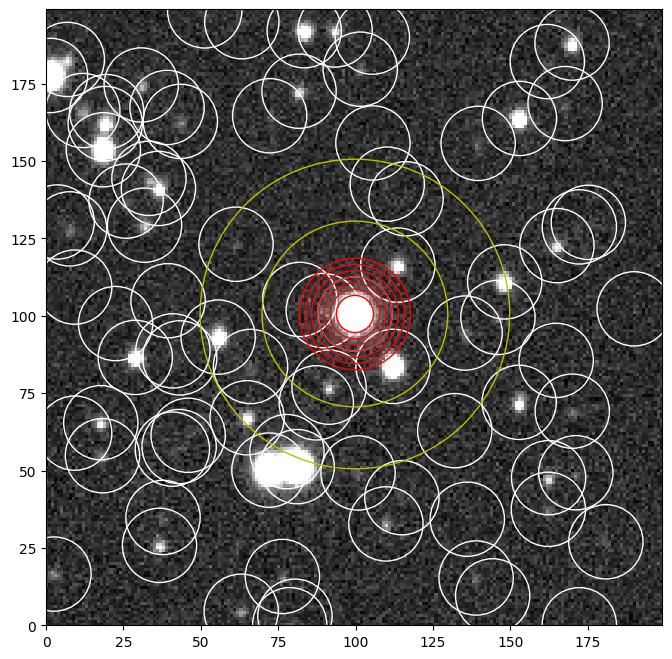

In [36]:
import numpy as np

c = ref.cutout(ref.sources[tid].coords, (200, 200))
c.show(zscale=True, sources=False)

c.fov = c.shape*ref.header['pixscale']*u.arcsec #need to add fov attribute before querying Gaia
c = catalogs.GaiaCatalog(mode="replace")(c)
c.plot_catalog("gaia", label=False, color="w")

# aperture radii
for r in aper_radii: 
    c.sources[0].plot(r, label=False, c="r")
    
# background annulus
dr = 20
rin = aper_rad_max_pix+10
rout = rin+dr #in units of fwhm
c.sources[0].plot(rin, label=False, c="y")
c.sources[0].plot(rout, label=False, c="y")

## check PSF model

Text(0.5, 1.0, 'diff')

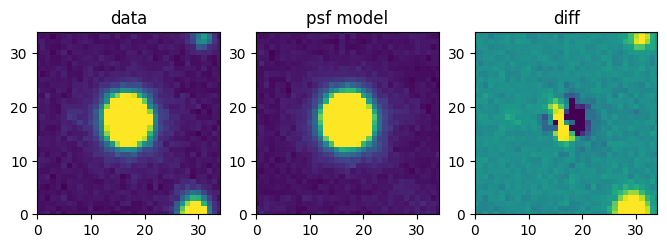

In [37]:
import matplotlib.pyplot as pl
from prose import Image

cmap='viridis'

fig, axs = pl.subplots(1,3, figsize=(8,3))
ax = axs.flatten()

c=ref.computed['cutouts'][tid]
c.show(ax=ax[0], cmap=cmap)
ax[0].set_title('data')
epsf=ref.computed['epsf']
epsf.show(ax=ax[1], cmap=cmap)

# params = epsf.params
# model = Image(epsf.model(params))
# model.show(ax=ax[1], cmap=cmap)
ax[1].set_title('psf model')
d = Image(c.data/c.data.max()-epsf.data)
d.show(ax=ax[2], cmap=cmap)
ax[2].set_title('diff')

## reduction

In [80]:
import numpy as np
from prose import FITSImage, Sequence, blocks
from prose.core.sequence import SequenceParallel

nstars = 10
cutout_shape = 31
scale_radii_to_fwhm = False 

def run_phot(data, ref, saturation=None):
    
    calibration = Sequence(
        [
            blocks.Trim(),
            blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # stars detection
            RejectSaturatedSources(saturation),
            blocks.Cutouts(shape=cutout_shape),  # stars cutouts
            blocks.MedianEPSF(),  # building EPSF
            blocks.psf.Moffat2D(),  # modeling EPSF
        ]
    )
    
    calibration.run(ref, show_progress=False)
    
    phot = SequenceParallel(
        blocks=[
                calibration[0],  # trim from calibration block (same as above)
                blocks.PointSourceDetection(n=nstars, min_area=20, min_separation=100),  # fewer stars detection
                RejectSaturatedSources(saturation),
                blocks.Cutouts(shape=cutout_shape),  # stars cutouts
                blocks.MedianEPSF(),  # building EPSF
                blocks.Gaussian2D(ref),  # modeling EPSF with initial guess
                blocks.ComputeTransformTwirl(ref, n=nstars),  # compute alignment
                blocks.AlignReferenceSources(ref),  # alignment
                blocks.CentroidQuadratic(),  # centroiding
                blocks.AperturePhotometry(aper_radii, scale=scale_radii_to_fwhm),  # aperture photometry
                blocks.AnnulusBackground(rin=rin, rout=rout, scale=scale_radii_to_fwhm),  # annulus background
                ],
        data_blocks=[
                blocks.GetFluxes(
                    "fwhm",
                    airmass=lambda im: im.header["AIRMASS"],
                    dx=lambda im: im.transform.translation[0],
                    dy=lambda im: im.transform.translation[1],
                    peak=lambda im: np.nanmax(im.data)
                ),
            ],
        )
        
    phot.run(data)
    
    return dict(phot=phot, ref=ref)

phot = {}
for band in bands:
    saturation = saturation_limits[band]
    phot[band] = run_phot(data[band], ref, saturation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 697/697 [00:41<00:00, 16.64images/s]


## photometry data

In [85]:
phot[band]['phot']

╒═════════╤════════╤════════════════════════╤════════════════╕
│   index │ name   │ type                   │ processing     │
╞═════════╪════════╪════════════════════════╪════════════════╡
│       0 │        │ Trim                   │ 0.008 s (100%) │
├─────────┼────────┼────────────────────────┼────────────────┤
│       1 │        │ PointSourceDetection   │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       2 │        │ RejectSaturatedSources │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       3 │        │ Cutouts                │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       4 │        │ MedianEPSF             │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       5 │        │ Gaussian2D             │ 0.000 s (0%)   │
├─────────┼────────┼────────────────────────┼────────────────┤
│       6 │        │ ComputeTransformTwirl  │ 0.000 s (

In [40]:
phot[band]['phot'].__dict__.keys()

dict_keys(['name', 'images', 'blocks_dict', 'data', 'n_processed_images', 'last_image', 'buffer', '_has_data', 'progress', 'discards'])

In [48]:
phot[band]['phot'].data[0].__dict__.keys()

dict_keys(['_time_key', '__doc__', 'name', 'unit_data', 'processing_time', 'runs', 'in_sequence', 'verbose', '_data_block', 'size', 'read', 'getters', 'values', 'arrays', '_parallel_friendly', 'fluxes'])

## reference frames

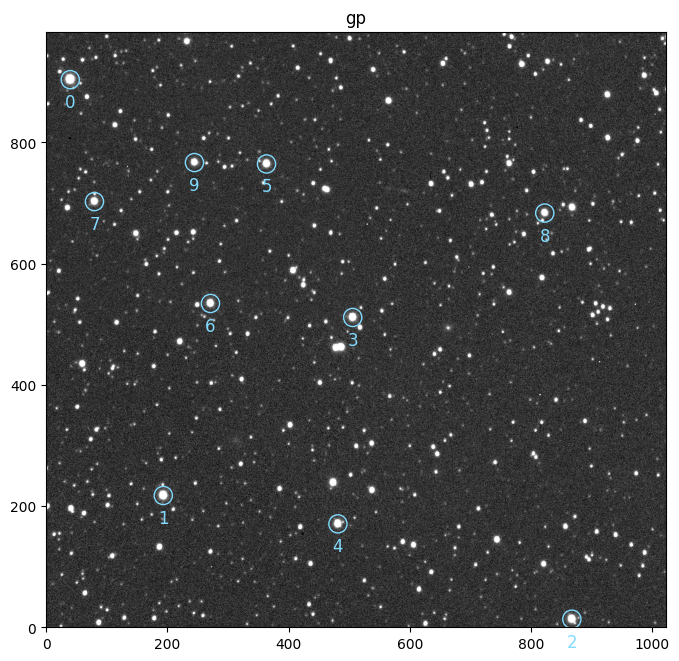

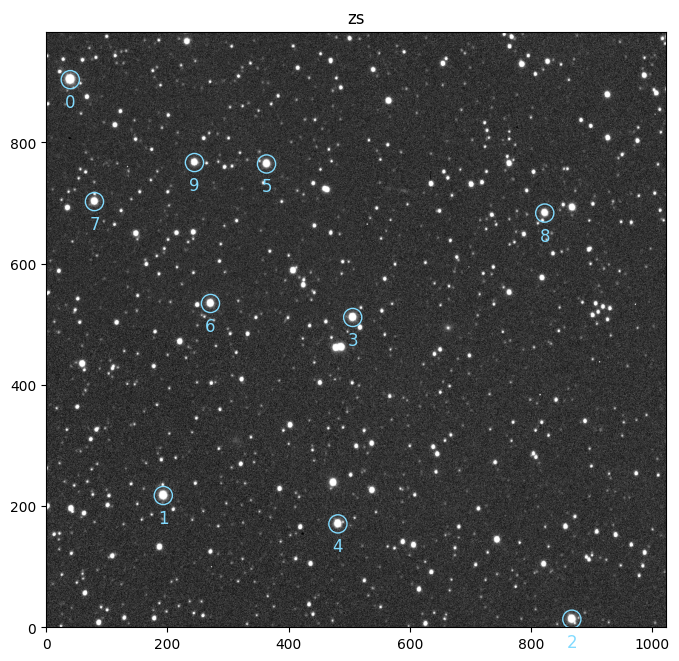

In [41]:
from prose import Fluxes
import matplotlib.pyplot as plt

for band in bands:
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    phot[band]['ref'].show()
    plt.title(band)

In [42]:
fluxes.__dict__.keys()

dict_keys(['fluxes', 'time', 'errors', 'data', 'apertures', 'weights', 'target', 'aperture', 'metadata'])

In [43]:
fluxes.target = tid
aper_idx = fluxes.best_aperture_index()
aper_idx

3

In [44]:
fluxes.shape #aper, nstars, ndata

(7, 10, 697)

## absolute photometry

## differential photometry

In [86]:
import matplotlib.pyplot as plt

def get_diff_phot(fluxes, target, plot=True, color='k', ax=None):
    
    fluxes.target = target
    
    # a bit of cleaning
    nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
    fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
    fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping
    
    # differential photometry
    diff = fluxes.autodiff()
    
    if plot:
        # plotting
        bin = diff.bin(10 / 60 / 24, estimate_error=True)            
        ax.errorbar(bin.time, bin.flux, bin.error, c=color, ls='', marker='o')
        diff.plot(ax=ax)
        if True:
            # show ingress, midpoint, egress
            ax.axvline(ing0[0], 0, 1, ls='--', c='k')
            ax.axvline(mid0[0], 0, 1, ls='-', c='k')
            ax.axvline(egr0[0], 0, 1, ls='--', c='k')
    return diff

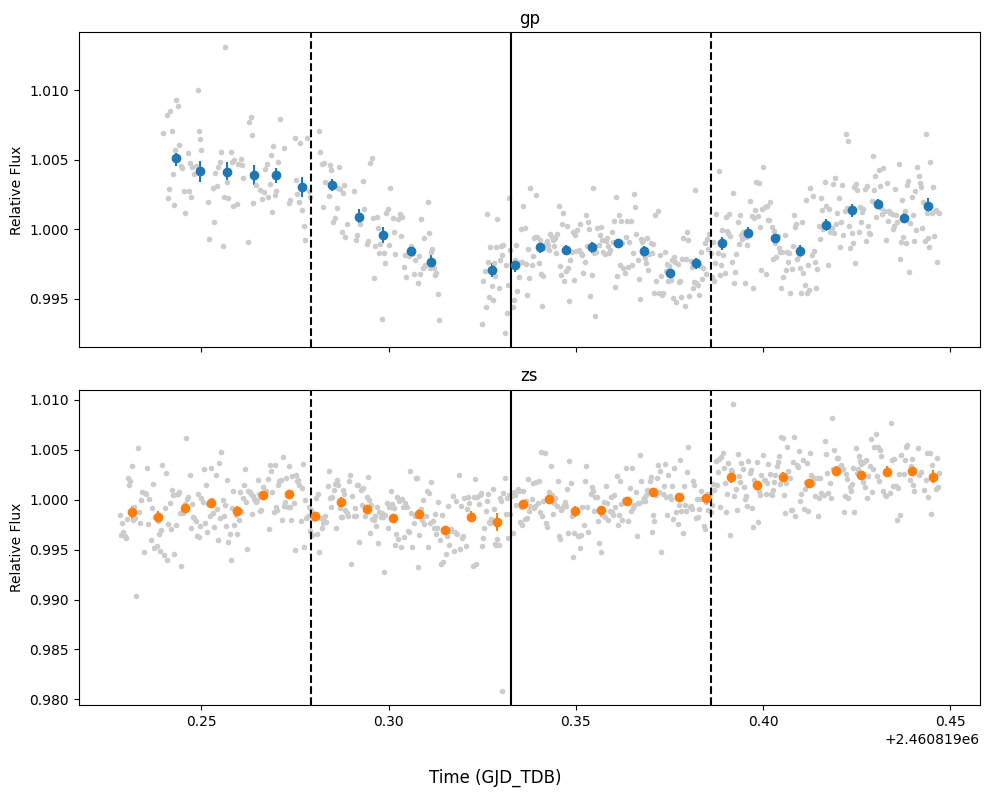

In [87]:
diffs = {}
tids = [tid]*len(bands)
fig, axs = plt.subplots(len(bands), 1, figsize=(10, 8), sharex=True)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=True, color=f'C{i}', ax=axs[i])
    diffs[band] = diff
    axs[i].set_title(band)
    axs[i].set_ylabel("Relative Flux")
fig.supxlabel("Time (GJD_TDB)")
fig.tight_layout()

In [89]:
diff.data.keys()

dict_keys(['bkg', 'airmass', 'dx', 'dy', 'peak', 'fwhm'])

## GJD_UTC to BJD_TDB conversion

In [90]:
from astroplan import Observer
from astropy.coordinates import SkyCoord
from astropy.time import Time

lco_sites = {
    # astroplan observatory site codes
    # LCO-1m
    "LCOGT node at SAAO": "saao",
    "LCOGT node at Tenerife": "teide",
    "LCOGT node at McDonald Observatory": "McDonald",
    "LCOGT node at Cerro Tololo Inter-American Observatory": "cerro tololo interamerican observatory",
    # LCO-2m
    "LCOGT node at Haleakala Observatory" : "Haleakala",
    "LCOGT node at Siding Spring Observatory": "Siding Spring Observatory",
    }
lco_codes = {
    #lco observatory site codes
    "LCOGT node at Siding Spring Observatory": "coj",
    "LCOGT node at Cerro Tololo Inter-American Observatory": 'lsc',
    "LCOGT node at SAAO": 'cpt',
    "LCOGT node at Tenerife": 'tfn'
}

site = ref.header['site']
obs_site = Observer.at_site(lco_sites[site])
obj_coord = SkyCoord(ra=ra, dec=dec, unit=("deg","deg"))

use_barycorrpy = False

bjds = {}
for band in bands:
    gjd = diffs[band].time
    t = Time(gjd, format='jd', scale='utc', location=obs_site.location)

    if use_barycorrpy:
        #https://arxiv.org/pdf/1801.01634.pdf
        try:
            from barycorrpy import utc_tdb
        except:
            raise ImportError("pip install barycorrpy")
        #convert jd to bjd_tdb
        result = utc_tdb.JDUTC_to_BJDTDB(t.value, 
                                         ra=obj_coord.ra.deg, 
                                         dec=obj_coord.dec.deg, 
                                         lat=obs_site.location.lat.deg, 
                                         longi=obs_site.location.lon.deg, 
                                         alt=obs_site.location.height.value)
        bjds[band] = result[0]
        offset = result[0]-t.value        
    else:
        #BJD time format in TDB time scale
        #see MuSCAT2_transit_pipeline/muscat2ph/phdata.py l218
        lttd = t.light_travel_time(obj_coord, kind='barycentric')
        bjd_tdb = t.tdb + lttd
        bjds[band] = bjd_tdb
        offset = bjd_tdb.value - t.jd
        #check difference between two time scales (should be < 8 mins!)
    offset_in_minutes = np.median(offset)*24*60
    msg = f"computed GJD-TDB offset={offset_in_minutes:.3} min"
    assert offset_in_minutes<=2*8.3, errmsg+" > 2*8.4 min!"
print(msg)

computed GJD-TDB offset=9.34 min


## export photometry into csv

In [91]:
import pandas as pd

save_csv = True
outdir = "."
date = ref.header['DAY-OBS'][2:]

for band,diff in diffs.items():
    df = diff.df.copy()
    df['BJD_TDB'] = bjds[band]
    df['Flux_Err'] = diff.error
    # rename columns
    df = df.rename({'time': 'GJD_UTC',
                    'flux': 'Flux',
                    'airmass': 'Airmass',
                    'dx': 'Dx(pix)',
                    'dy': 'Dy(pix)',
                    'bkg': 'Bkg(ADU)',
                    'fwhm': 'FWHM(pix)',
                    'peak': 'Peak(ADU)'
                   }, axis=1)
    print(df.head())
    if save_csv:
        fp = f"{outdir}/{target_name.replace(' ', '')}_{date}_{inst.lower()}_{lco_codes[site]}_{band[0]}_prose.csv"
        df.to_csv(fp, index=False)
        print("Saved: ", fp) 

    Bkg(ADU)   Airmass   Dx(pix)    Dy(pix)     Peak(ADU)  FWHM(pix)  \
0  94.235911  1.660693 -3.304323 -14.379677  47663.863281   3.441818   
1  94.656318  1.650246 -2.634146 -17.731419  35628.199219   3.499104   
2  94.064083  1.646864 -3.357823 -14.248301  54532.445312   3.195077   
3  94.028267  1.643501 -2.944451 -14.292672  54095.550781   3.244659   
4  93.726484  1.639664 -3.617995 -13.155505  43181.183594   3.247450   

        GJD_UTC      Flux             BJD_TDB  Flux_Err  
0  2.460819e+06  1.006937  2460819.2462390168  0.002306  
1  2.460819e+06  1.008222  2460819.2472041054  0.002291  
2  2.460819e+06  1.002256   2460819.247519174  0.002310  
3  2.460819e+06  1.002923  2460819.2478328417  0.002309  
4  2.460819e+06  1.008513   2460819.248196023  0.002303  
Saved:  ./TIC89071445_250523_sinistro_cpt_g_prose.csv
     Bkg(ADU)   Airmass   Dx(pix)    Dy(pix)     Peak(ADU)  FWHM(pix)  \
0  392.196489  1.798762  0.307227 -49.849675  57783.742188   2.515241   
1  389.125842  1.79

In [92]:
# custom format for allesfitter
b = 'g'
df = pd.read_csv(f'./TIC89071445_250523_sinistro_cpt_{b}_prose.csv')
outdir = '/ut3/jerome/github/research/project/young_targets/vach25_candidates'
fp = f'{outdir}/TIC-89071445/allesfitter/tess_lco2/wo_rhostar_prior/lco_{b}2.csv'
cols = ['BJD_TDB','Flux','Flux_Err']
df[cols].to_csv(fp, header=False, index=False)

## plots

Text(0.5, 0.98, 'TIC89071445 | Sinistro | 250523')

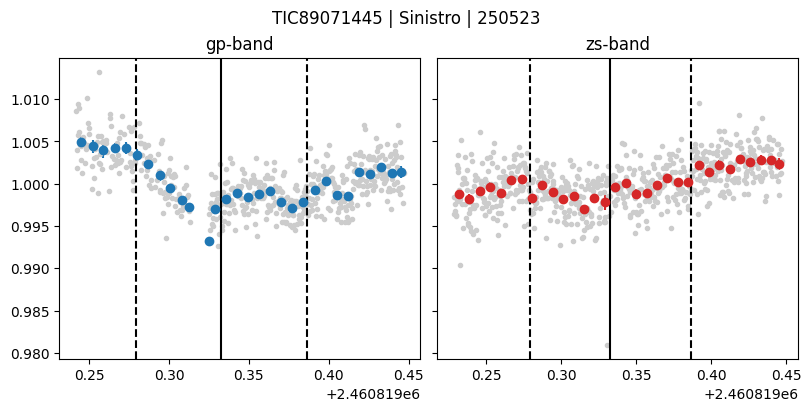

In [93]:
import pandas as pd

fig, axs = pl.subplots(1, 2, figsize=(8,4), sharex='col', sharey='row', constrained_layout=True)
ax = axs.flatten()
for i,band in enumerate(bands):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2)) # stars with nan fluxes
    fluxes = fluxes.mask_stars(~nan_stars) # mask nans stars
    fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3) # sigma clipping
    diff = get_diff_phot(fluxes, tid, plot=True, color=f'C{i*3}', ax=ax[i])
    ax[i].set_title(f"{band}-band")
fig.suptitle(f"{target_name} | {inst} | {date}")

And here is our planetary transit. To validate the differential photometry and the automatic choice of comparison stars, we can plot their light curves along the target light curve

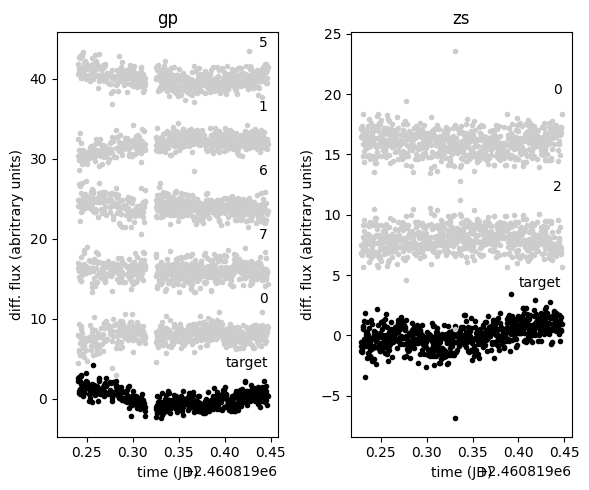

In [97]:
def plot_comp(diff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))
    
    # plotting only the first five comparisons
    for j, i in enumerate([diff.target, *diff.comparisons[0:5]]):
        y = diff.fluxes[diff.aperture, i].copy()
        y = (y - np.mean(y)) / np.std(y) + 8 * j
        ax.text(
            diff.time.max(), np.mean(y) + 4, i if i != diff.target else "target", ha="right"
        )
        ax.plot(diff.time, y, ".", c="0.8" if i != diff.target else "k")

    plt.setp(ax, xlabel="time (JD)", ylabel="diff. flux (abritrary units)")
    
fig, axs = plt.subplots(1, len(bands), figsize=(3*len(bands), 5), sharex=True, sharey=False)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=False)
    plot_comp(diff, ax=axs[i])
    axs[i].set_title(band)

fig.tight_layout()

# Explanatory measurements

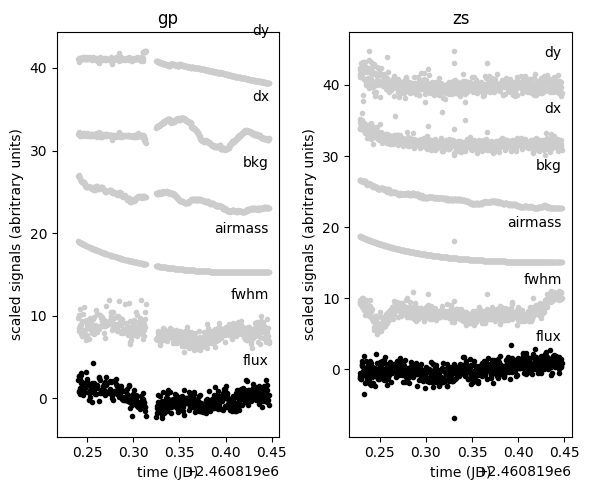

In [56]:
def plot_aux(diff, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))
    
    for i, name in enumerate(["flux", "fwhm", "airmass", "bkg", "dx", "dy", "peak"]):
        y = diff.df[name].copy()
        y = (y - np.mean(y)) / np.std(y) + 8 * i
        ax.text(diff.time.max(), np.mean(y) + 4, name, ha="right")
        ax.plot(diff.time, y, ".", c="0.8" if name != "flux" else "k")

    plt.setp(ax, xlabel="time (JD)", ylabel="scaled signals (abritrary units)")

fig, axs = plt.subplots(1, len(bands), figsize=(3*len(bands), 5), sharex=True, sharey=False)
for i, (band, tid) in enumerate(zip(bands, tids)):
    fluxes: Fluxes = phot[band]['phot'].data[0].fluxes
    diff = get_diff_phot(fluxes, tid, plot=False)
    plot_aux(diff, ax=axs[i])
    axs[i].set_title(band)
    
fig.tight_layout()

## quick look plot

In [3]:
import sys
sys.path.insert(0, "/ut3/muscat/github/tfop_code/")

In [100]:
import pandas as pd

data = {}
target_name = 'TIC89071445'
date = 250523
instrument = 'sinistro'
site = 'cpt'
pipeline = 'prose'
data['g'] = pd.read_csv(f'./{target_name}_{date}_{instrument}_{site}_g_{pipeline}.csv')
data['z'] = pd.read_csv(f'./{target_name}_{date}_{instrument}_{site}_z_{pipeline}.csv')

In [ ]:
from tfop_analysis import plot_ql, colors
from aesthetic.plot import savefig

exptimes = {'g': 20, 'z': 20}
for i,b in enumerate(data):
    fig = plot_ql(data[b],
                  title=f'{target_name}.01 | LCO-1m/{instrument} | {date} | {b}=band',
                  exptime=exptimes[b],
                  mcolor=colors[b],
                  binsize=10/60/24,
                  figsize=(10,10),
                  font_size=16,
                  title_height=0.93
                 )
    if False:
        outfile = f"{outdir}/{target}.01_{date}_{inst}_{b}_ql.pdf"
        fig.savefig(outfile, dpi=300)